In [ ]:
# Importación de dependencias necesarias
from pathlib import Path
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [3]:
# Carga del dataset
data = np.load("../data/synthetic_2d_v2.npz")
X_train, X_test = data["X_train"], data["X_test"]
y_train, y_test = data["y_train"], data["y_test"]

models = {
    "logreg": LogisticRegression(
        C=1.0,
        solver="lbfgs",
        max_iter=500
    ),
    "svc_rbf": SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        probability=True  # importante para tener predict_proba
    ),
    "mlp": MLPClassifier(
        hidden_layer_sizes=(32, 32),
        activation="relu",
        max_iter=1000
    ),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results[name] = (acc, auc, model)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"ROC-AUC:  {auc:.4f}")
    print()

# Elegimos logreg como base, y por ejemplo svc_rbf como defensor más fuerte
logreg = results["logreg"][2]
svc_rbf = results["svc_rbf"][2]

Path("../classifiers").mkdir(exist_ok=True, parents=True)
joblib.dump(logreg, "../classifiers/logreg_synthetic_2d.joblib")
joblib.dump(svc_rbf, "../classifiers/svc_rbf_synthetic_2d.joblib")


=== logreg ===
Accuracy: 0.9150
ROC-AUC:  0.9736

=== svc_rbf ===
Accuracy: 0.9100
ROC-AUC:  0.9608

=== mlp ===
Accuracy: 0.9075
ROC-AUC:  0.9760



['../classifiers/svc_rbf_synthetic_2d.joblib']

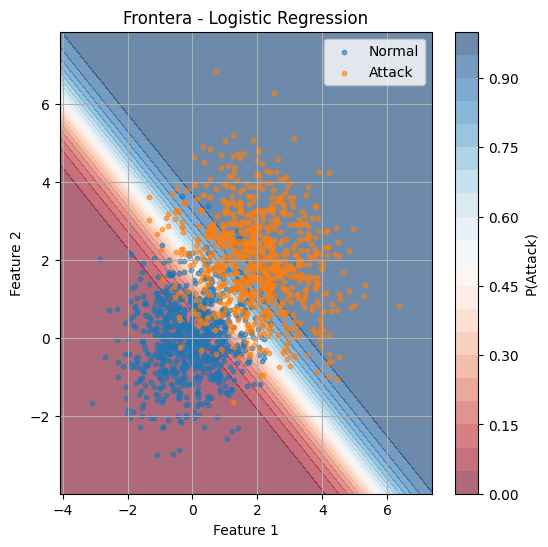

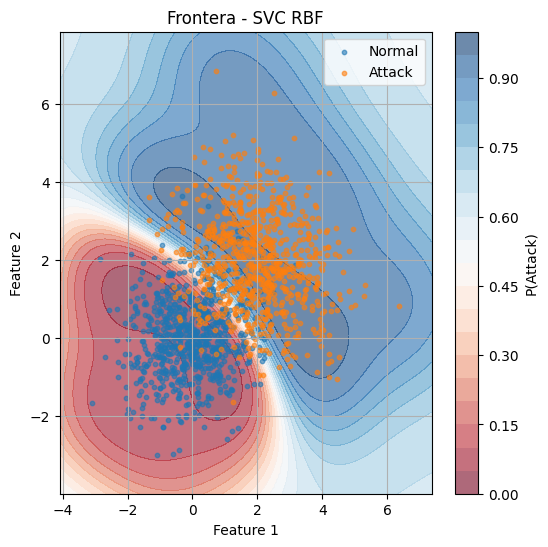

In [6]:
def plot_decision_boundary(clf, X_train, y_train, title):
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]
    probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, probs, levels=20, alpha=0.6, cmap="RdBu")
    plt.colorbar(label="P(Attack)")

    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], s=10, alpha=0.6, label="Normal")
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], s=10, alpha=0.6, label="Attack")

    plt.legend()
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title)
    plt.grid(True)
    plt.show()

# Frontera del clasificador base (logreg)
plot_decision_boundary(logreg, X_train, y_train, "Frontera - Logistic Regression")

# Frontera del clasificador más fuerte (SVC RBF)
plot_decision_boundary(svc_rbf, X_train, y_train, "Frontera - SVC RBF")
